# Material Balances XII

This lecture covers reactor sequencing using Levenspiel Plots

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import quad, solve_ivp
from scipy.interpolate import interp1d
from math import ceil, floor

**Flow Reactors in Series**

We continue consideration of a simple, irreversible reaction:

$$A \longrightarrow B$$

We will state explicity that examples in this notebook will apply the same simplifying assumptions that appear in **587-L20**. Specifically, all parameters $(k, \ C_{Af}, \ F_{Af}, \ Q)$ have a numerical value of 1, and units are always correct so that they a reactor volume in Liters.  We will also assume that density, temperature, pressure, volumetric flowrates, etc. are constant in this sequence of reactors.  The constant density assumption is used to make the following simplification, which makes solutions a bit neater:

$$C_A = C_{A,f} \, (1 - X_A)$$

We will now consider carrying out a reaction in a set of flow reactors in sequence instead of in a single flow reactor:

```{figure} ../images/ReactorsInSeries1.svg
---
height: 400px
name: directive-fig
---
Flow Reactors in Series
```

We can express the molar flowrate at any point in this sequence in terms of the feed molar flowrate to the *process*, $F_{A0}$ and the overall conversion achieved at a particular point in the sequence.  In other words:

\begin{align}
    F_{A0} &= F_{A0} \, (1 - X_{A0}) = F_{A0}  - F_{A0}X_{A0}\\
    F_{A1} &= F_{A0} \, (1 - X_{A1}) = F_{A0}  - F_{A0}X_{A1}\\
    F_{A2} &= F_{A0} \, (1 - X_{A2}) = F_{A0}  - F_{A0}X_{A2}\\
    F_{A3} &= F_{A0} \, (1 - X_{A3}) = F_{A0}  - F_{A0}X_{A3}\\
    F_{A4} &= F_{A0} \, (1 - X_{A4}) = F_{A0}  - F_{A0}X_{A4}\\
\end{align}

Let's recall our generic balance on a single CSTR solved for Volume:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

And the same for a generic balance on a single PFR solved for Volume:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Looking at those, we can remind ourselves that the size of the reactor will scale directly with the quantity of species converted in that reactor.  The more stuff that we convert in the reactor, the larger it needs to be.  Let's generalize the concept of the quantity of stuff that gets converted in the reactor.  For example, you could look at Reactor 1 and say that the quantity of $A$ consumed in Reactor 1 is given by $F_{A0} - F_{A1}$.  We can express that quantity in terms of conversion using the results above:

$$F_{A0} - F_{A1} = [F_{A0}  - F_{A0}X_{A0}] - [F_{A0}  - F_{A0}X_{A1}]$$

We can simplify this significantly:

$$F_{A0} - F_{A1} = F_{A0} \, (X_{A1} - X_{A0})$$

Similarly, if we wanted to express the quantity of A converted across the second reactor in terms of the process feed, $F_{A0}$, and fractional conversions, we would write:

$$F_{A1} - F_{A2} = [F_{A0}  - F_{A0}X_{A1}] - [F_{A0}  - F_{A0}X_{A2}]$$

Which simplifies to:

$$F_{A1} - F_{A2} = F_{A0} \, (X_{A2} - X_{A1})$$

We can see a pattern emerging -- for the "nth" flow reactor in a series, we can quantify the amoutn of reactant converted in that reactor as:

$$F_{A_{(n-1)}} - F_{A_n} = F_{A0} \, \left(X_{A_n} - X_{A_{(n-1)}}\right)$$

**Consider the nth reactor**

Now, let's think conceputally about that n<sup>th</sup> reactor in the sequence (see figure below):

```{figure} ../images/ReactorsInSeriesn.svg
---
height: 400px
name: directive-fig
---
Flow Reactors in Series
```

If we were to write a CSTR balance on the nth reactor, we'd find:

$$0 = F_{A_{(n-1)}} - F_{A_n} + R_{A_n}V_{\textrm{CSTR}_n}$$

We can solve this for the volume of the $n^{th}$ reactor:

$$V_{\textrm{CSTR}_n} = \frac{F_{A_{(n-1)}} - F_{A_n}}{-R_{A_n}}$$

And recognizing that, for this $A \longrightarrow B$ reaction, $R_{A_n} = -r_n$:

$$V_{\textrm{CSTR}_n} = \frac{F_{A_{(n-1)}} - F_{A_n}}{r_n}$$

Where, importantly, the rate of reaction is determined by the concentration ***inside*** of the $n^{th}$ reactor, which is equal to the concentration in the ***exit stream*** from the $n^{th}$ reactor.  We can replace the difference in molar flowrates in the numerator with the fractional conversion expression from above to get:

$$V_{\textrm{CSTR}_n} = \frac{F_{A0}}{r_n} \, \left(X_{A_n} - X_{A_{(n-1)}}\right)$$

In order to actually solve this, we have to specify a rate law.  We'll again use the generic power law kinetics that we've been assuming so far:

$$r = k{C_A}^\alpha$$

With that, I can write a generic function to solve for the nth CSTR in a sequence.  All I need to do is give it the fractional conversion into that CSTR, $X_{A_{(n-1)}}$, the fractional conversion out of that CSTR, $X_{A_n}$, and the reaction order $\alpha$.

In [3]:
def VCSTR(XAin, XAout, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = CAf*(1 - XAout)
    r   = k*CA**α
    V   = FAf*(XAout - XAin)/r
    return V

Now that we have this, we'll use it to calculate the CSTR volume required to take the system from 0% to 90% conversion across a single reactor; we find that it is 9.0L as usual.

In [4]:
α_test = 1
XA0 = 0.0
XA1 = 0.9

VC  = VCSTR(XA0, XA1, α_test)
print(f'For α = {α_test:3.1f}: \n XA = {XA1:4.2f} at VCSTR = {VC:3.2f}L')

For α = 1.0: 
 XA = 0.90 at VCSTR = 9.00L


Now let's do something different.  Let's set up two CSTRs in series and have them achieve 90% conversion together. For simplicity, we'll have the first CSTR achieve 45% conversion (it takes the system from 0% conversion to 45% conversion), and we'll have the second CSTR achieve the remainder (it takes the system from 45% conversion to 90% conversion).

In [29]:
α_test = 1
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90

VC1 = VCSTR(XA0, XA1, α_test)
VC2 = VCSTR(XA1, XA2, α_test)
VCT = VC1 + VC2
print(f'Achieving 90% conversion in a single CSTR requires V = {VC:3.2f}L \n')
print(f'Going from 0% to 45% conversion requires  V1 = {VC1:3.2f}L')
print(f'Going from 45% to 90% conversion requires V2 = {VC2:3.2f}L')
print(f'If we use two CSTRs to get to 90%, the total volume is V = {VCT:3.2f}L')

Achieving 90% conversion in a single CSTR requires V = 9.00L 

Going from 0% to 45% conversion requires  V1 = 0.82L
Going from 45% to 90% conversion requires V2 = 4.50L
If we use two CSTRs to get to 90%, the total volume is V = 5.32L


That's interesting!  The first CSTR requires 0.82L of volume to go to 45% conversion, and the second reactor requires 4.50L to go from 45% to 90% conversion.  If we add those together, that's 5.32L of total CSTR volume if we divide the system into 2 CSTRs, each accomplishing half of the required conversion.  In contrast, if we try to do this in a single CSTR, it costs us 9.0L of reactor volume.

Why is that so?  It has to do with the fact that CSTR are assumed to be perfectly mixed, and they operate entirely at the exit conversion.  If we try to achive 90% conversion in a single reactor, that entire reactor operates at 90% conversion, where the concentration of $A$ is 10% of its feed value.  For a positive order, that means the rate is actually quite low throughout the reactor, so it takes 9.0L of volume.

In contrast, if we divide this into two reactors, the first one operates at 45% conversion, so the concentration in that reactor is $0.55C_{Af}$.  For a positive order reaction, this means the rate in that first reactor is realtively high compared to a CSTR operating at 90% conversion ($0.1C_{Af}$). So that reactor converts 45% of the feed at a relatively high reaction rate; hence the relatively small size.

The second reactor is operating at 90% conversion ($0.1C_{Af}$), which means a very low reaction rate for a positive order reaction; however, it now only has to convert 45% of the feed, so the "stuff" converted at that low rate is less, and we have a smaller second reactor than the 9.0L we'd need to convert 90% of the feed in a single CSTR.  This is very easy to see on a Levenspiel Plot.

In [6]:
def LEV(XA, α):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    CA  = CAf*(1 - XA)
    r   = k*CA**α
    return FAf/r

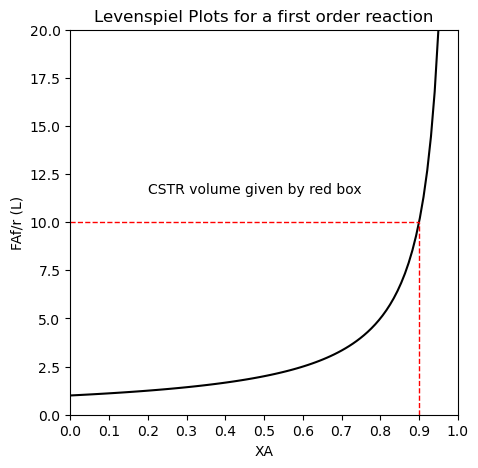

In [24]:
order = 1
XAset = np.linspace(0, 0.95, 100)
plt.figure(1, figsize = (5, 5))
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.title('Levenspiel Plots for a first order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

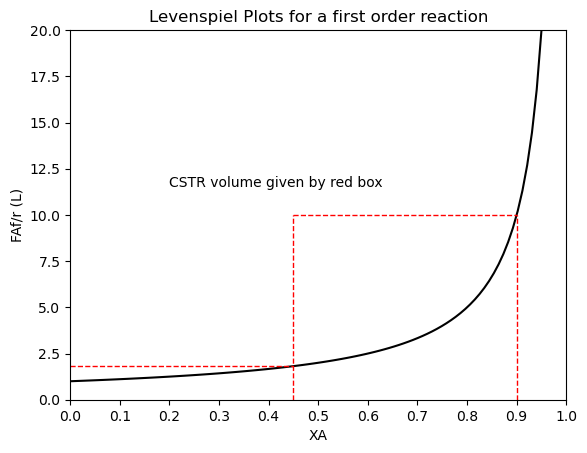

In [23]:
order = 1
XAset = np.linspace(0, 0.95, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.45, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.45, order), 0, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.title('Levenspiel Plots for a first order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Now let's consider the implications for a series of PFRs.  Recall that if we solve a PFR balance for volume in a single reactor, we get the following result:our general balance is given by the following expression:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

This balance actually allows for continuous variation in rate as a function of fractional conversion...so we really don't need to modify it much to consider the volume of the nth reactor.  All we do to change it is to realize that calculating the volume of a PFR in the above expression requires us to integrate from the conversion at the inlet of that reactor (it is zero for a single reactor) to the exit of that reactor (it is whatever conversion we're trying to achieve for a single reactor).  If we want to think about the $n^{th}$ reactor in a series of PFRs, we would just account for this by generalizing the limits of integration.  I'm also changing the $F_{A,f}$ to an $F_{A0}$ to reflect that we're specifying the fractional conversion at points $(n-1)$ and n relative to point 0, i.e., which is typically the inlet to the process.

$$V_{\textrm{PFR}_n} = \int_{X_{A_{(n-1)}}}^{X_{A_n}} \frac{F_{A0} \, dX_A}{r \, (X_A)}$$

Once we have a rate law, we can solve this either analytically, with an ODE solver, or, in this case, since it is just a definite integral, using gaussian quadrature.  I'll take the last option here since it is easy for me to generalize for any reaction order, and I can keep my rate law generic, i.e.,:

$$r = k{C_A}^\alpha$$

In [9]:
def VPFR(XAin, XAout, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = lambda X: CAf*(1 - X)
    r   = lambda X: k*CA(X)**α
    intfun   = lambda X: FAf/r(X)
    vol, err = quad(intfun, XAin, XAout)
    return vol

Now that this is done, we'll calculate the PFR volume required to take the system from 0% conversion to 90% conversion in a single reactor:

In [10]:
α_test
XA0 = 0.0
XA1 = 0.9

VP  = VPFR(XA0, XA1, 1)
print(f'For α = {α_test:3.1f}: \n XA = {XA1:4.2f} at VPFR = {VP:3.2f}L')

For α = 1.0: 
 XA = 0.90 at VPFR = 2.30L


We find that it is 2.30L, just like we did in the last lecture where we developed a solution for a single PFR.  Now let's divide it into 2 PFRs in sequence.  The first one will take the system from 0% to 45% conversion, and the second one will take the system from 45% to 90% conversion.

In [22]:
α_test = 1
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90

VP1 = VPFR(XA0, XA1, α_test)
VP2 = VPFR(XA1, XA2, α_test)
VPT = VP1 + VP2
print(f'Achieving 90% conversion in a single PFR requires V = {VP:3.2f}L \n')
print(f'Going from 0% to 45% conversion requires  V1 = {VP1:3.2f}L')
print(f'Going from 45% to 90% conversion requires V2 = {VP2:3.2f}L')
print(f'If we use two PFRs to get to 90%, the total volume is V = {VPT:3.2f}L')

Achieving 90% conversion in a single PFR requires V = 2.30L 

Going from 0% to 45% conversion requires  V1 = 0.60L
Going from 45% to 90% conversion requires V2 = 1.70L
If we use two PFRs to get to 90%, the total volume is V = 2.30L


Huh.  We see that each reactor is smaller, but that makes sense because they are accomplishing less conversion compared to the single, 2.30L reactor that is achieving 90% conversion in one shot.  But if we add them up, we get an identical result to what we got for a single PFR.  Again, the reason for this is evident if you look at a Levenspiel plot:

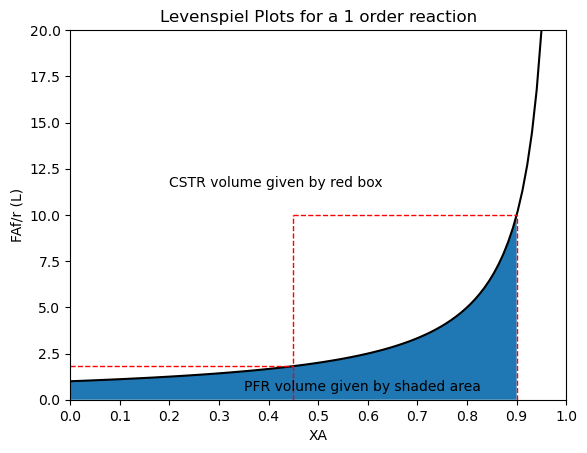

In [12]:
order = 1
XAset = np.linspace(0, 0.95, 100)
XAPFR = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.45, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.45, order), 0, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Since PFRs take the system from inlet conditions to exit conditions in a series of differential steps, the volume of the PFR is given by the area under the Levenspiel curve, and there is absolutely no difference if we use a single PFR or if we divide the system into two PFRs.

The code cell below is generalized so that you can compare the total PFR and CSTR volumes required to achieve any desired conversion for any desired reaction order.

The total PFR volume required is  V = 2.30L
The total CSTR volume required is V = 2.77L


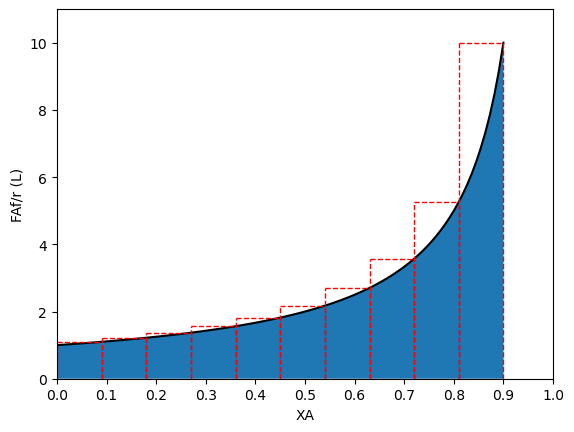

In [13]:
order = 1
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))

XAMAX = max(XAset)
NREAC = 10
XAVAL = np.linspace(0, XAMAX, NREAC+1)
VCSET = np.zeros(len(XAVAL))
for i in range(0, len(XAVAL)-1):
    plt.vlines(XAVAL[i], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.vlines(XAVAL[i+1], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.hlines(LEV(XAVAL[i+1], order), XAVAL[i], XAVAL[i+1], linestyle = 'dashed', color = 'red', linewidth = 1)
    VCSET[i] = VCSTR(XAVAL[i], XAVAL[i+1], order)
VPTOT = VPFR(XAset[0], XAset[-1], order)

print(f'The total PFR volume required is  V = {VPTOT:3.2f}L') 
print(f'The total CSTR volume required is V = {sum(VCSET):3.2f}L')

plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Now let's consider why these concepts might be useful.  Below, I create a Levenspiel plot based on an arbitrary rate law that I have made up entirely so that the rate is parabolic and has a maximum value at around 45% conversion or so.  This is not a completely contrived example, by the way.  This is actually very commonly encountered when we run exothermic reactions in adiabatic reactors.  The reactor increases in temperature due to the heat released by reaction, and this increases the magnitude of the rate constant and accelerates the reaction.  Eventually, the concentration of $A$ decreases to the point where it negates the effect of an increasing rate constant, and the reaction begins to slow down again (with increasing conversion).  I am mimicking this scenario with this example.

In [14]:
def rmod(XA):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    r   = 1 - 3*(XA - 0.45)**2
    return r

def LEVmod(XA):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    r   = 1 - 3*(XA - 0.45)**2
    return FAf/r

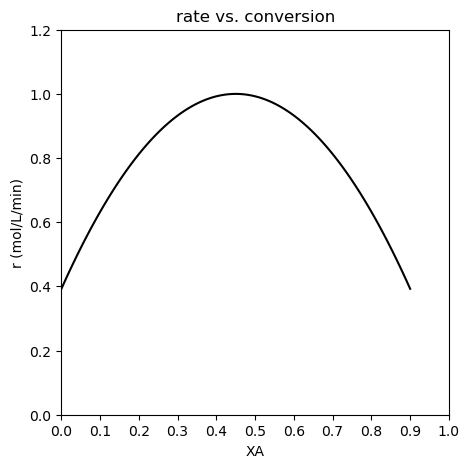

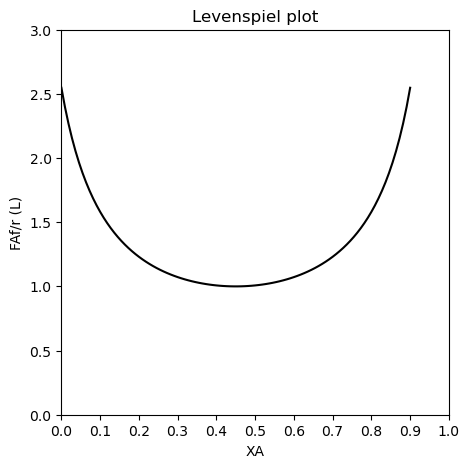

In [15]:
XAset  = np.linspace(0, 0.90, 100)
XAPFR1 = np.linspace(0.45, 0.9, 100)
XAPFR2 = np.linspace(0.0, 0.45, 100)

plt.figure(figsize = (5, 5))
plt.plot(XAset, rmod(XAset), color = 'black')
plt.title('rate vs. conversion')
plt.ylabel('r (mol/L/min)')
plt.xlabel('XA')
plt.xlim(0, 1)
plt.ylim(0, ceil(max(rmod(XAset)))*1.2)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

plt.figure(figsize = (5,5))
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.title('Levenspiel plot')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Now let's say we want to achieve 90% conversion of species A in this system. Below, we illustrate the case for carrying this out in a single PFR.

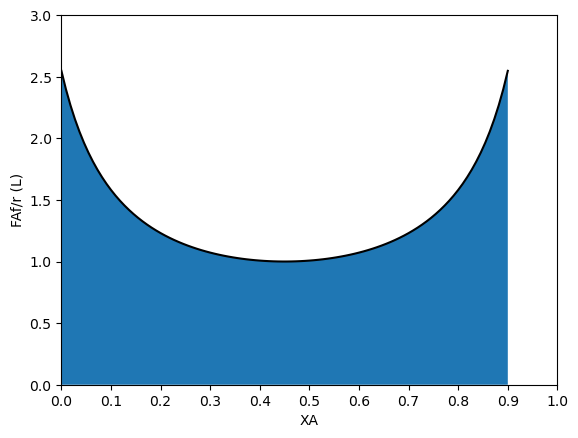

In [16]:
#Use for a single PFR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.fill_between(XAset, LEVmod(XAset))
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Next, we consider the same transformation in a single CSTR

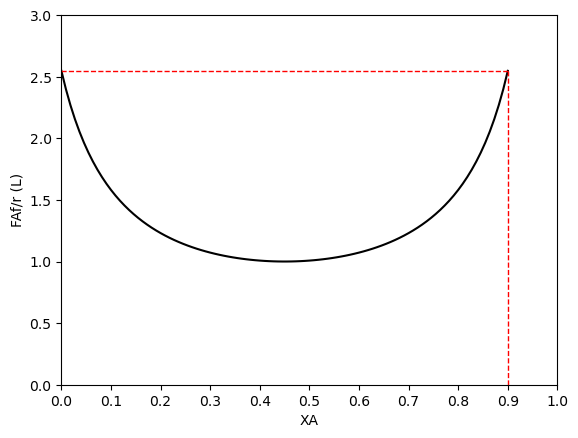

In [17]:
#Use for a single CSTR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.9, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(0.9), 0.00, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

We can compare that to using 2 CSTRs in series; there is an important question of what the intermediate conversion out of the first reactor should be to minimize reactor volume. It is not obvious where that intermediate conversion should be; we would need to perform some type of optimization strategy to determine this. We will save that for a future lecture after we cover optimization methods.

The total CSTR volume required is V = 1.60L


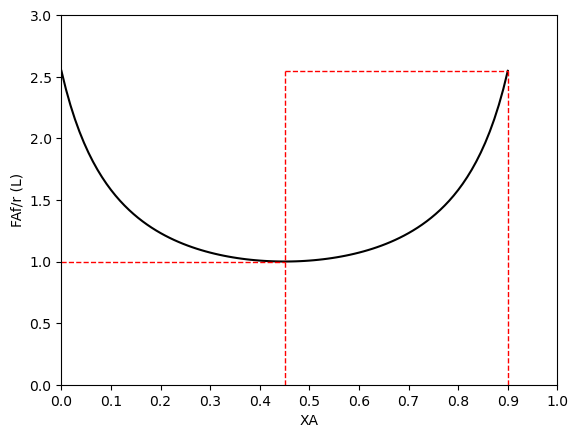

In [18]:
#Use for 2 CSTRs in series
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90
VC1 = LEVmod(XA1)*(XA1 - XA0)
VC2 = LEVmod(XA2)*(XA2 - XA1)
VCT = VC1 + VC2
print(f'The total CSTR volume required is V = {VCT:3.2f}L')
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(XA2, XA0, LEVmod(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(XA1, XA0, LEVmod(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(XA2), XA1, XA2, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(XA1), XA0, XA1, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Now let's try mixing reactors; we'll put a CSTR in series downstream of a PFR and operate the PFR so that it achieves 45% conversion:

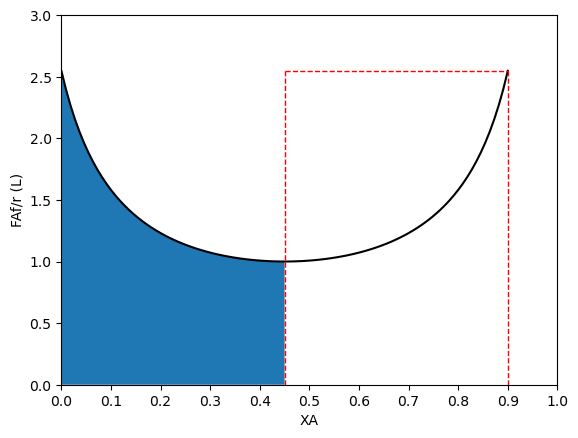

In [19]:
#Use for a PFR before a CSTR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.9, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(XAPFR2, LEVmod(XAPFR2))
plt.hlines(LEVmod(0.9), 0.45, 0.90, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

It is not intuitive at first, but if we switch the order and place the CSTR before the PFR, we get a much smaller total reactor volume:

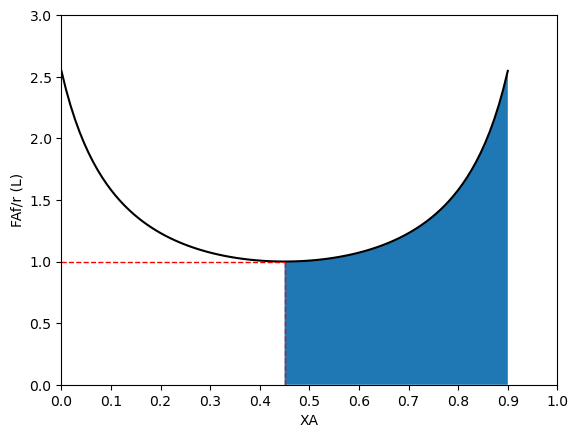

In [20]:
#Use for a CSTR before a PFR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.45, 0, LEVmod(0.45), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(XAPFR1, LEVmod(XAPFR1))
plt.hlines(LEVmod(0.45), 0.00, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

These trends make sense when you consider (1) the impact of mixing, (2) the relationship of reactor size and reaction rate, and (3) the point of maximum reaction rate in this system. Essentially, you will be able to minimize reactor volume by ensuring that the system operates as close as possible to the maximum reaction rate for as long as possible.  The CSTR is perfectly mixed, so we can design it to operate at 45% conversion, i.e., the point of maximum reaction rate.  Thereafter, we'd like to gradually move from that point of maximum reaction rate (45% conversion) to the very low reaction rate we know we'll encounter at 90% conversion. A PFR is not mixed, and it will allow you to accomplish this gradual change in fractional conversion as a function of residence time (position in the reactor).